# Capstone 2 Modeling<a id='Modeling'></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [4 Modeling](#Modeling)
    * [4.1 Imports](#Imports)
        * [4.1.1 Import Libraries](#Import_Libraries)
        * [4.1.2 Import Data](#Import_Data)
        * [4.1.3 Import Models](#Import_Models)
    
    * [4.2 Hyperparameter Tuning](#Hyperparameter_Tuning)
        * [4.2.1 Random Search](#Random_Search)
        * [4.2.2 Bayesian Optimization](#Bayesian_Optimization)
    
    * [4.3 Confusion Matrix](#Confusion_Matrix)
    
    * [4.4 Classification Report](#Classification_Report)
    
    * [4.5 Feature Importance](#Feature_Importance)
            
    * [4.6 Modeling_Scenarios](#Modeling_Scenarios)
        * [4.6.1 Providing Discounts](#Providing_Discounts)
        * [4.6.2 Increasing User Engagement](#Increasing_User_Engagement)
        * [4.6.3 Smaller Plans](#Smaller_Plans)
        * [4.6.4 Auto-Renew](#Auto-Renew)
        * [4.6.5 Combining_Scenarios](#Combining_Scenarios)
        
    * [4.7 Statistical Significance](#Statistical_Significance)
       


## 4.1 Imports<a id="Imports"></a>

### 4.1.1 Import Libraries<a id="Import_Libraries"></a>

In [1]:
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import recall_score, plot_roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from scipy.stats import chi2_contingency

### 4.1.2 Import Data<a id="Import_Data"></a>

In [2]:
# Read in X_train and y_train
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")

In [3]:
# Read in X_test and y_test 
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

### 4.1.3 Import Models<a id="Import_Models"></a>

In [4]:
# Model with hyperparameters chosen by random search
rs_filepath = "../models/rs_model.pkl"
with open(rs_filepath, "rb") as f:
    rs_model = pickle.load(f)

# Model with hyperparameters chosen by Bayesian optimization
bo_filepath = "../models/bo_model.pkl"
with open(bo_filepath, "rb") as f:
    bo_model = pickle.load(f)

## 4.2 Hyperparameter Tuning<a id="Hyperparameter_Tuning"></a>

The following hyperparameters ranges were set: 

* eta (learning_rate): between 0.3 and 0.9
* max_depth: between 1 and 9
* min_child_weight: between 1 and 7
* colsample_bytree: between 0.1 and 0.8
* gamma: between 0.1 and 0.5

We searched this hyperspace using random search and Bayesian optimization on Google Cloud Platform (GCP). 

Code for this can be found here: https://github.com/bmensah/springboard/tree/main/capstone2/churn_analysis/src 

In [5]:
def show_params(model, param_list):
    """
    Given an xgboost model, print out the parameters listed in param list
    """
    param_dict = model.get_xgb_params()
    for param in param_list:
        print(param, " = ", param_dict[param])

In [6]:
param_list = ["eta","max_depth","min_child_weight", "colsample_bytree", "gamma"]

### 4.2.1 Random Search<a id="Random_Search"></a>

In [7]:
# Get train set performance
y_pred_train = rs_model.predict(X_train)
print("Train set performance: ", recall_score(y_train, y_pred_train))

# Get test set performance
y_pred_test = rs_model.predict(X_test)
print("Test set performance: ", recall_score(y_test, y_pred_test))

Train set performance:  0.674421539755995
Test set performance:  0.6417417417417417


In [8]:
# Best parameters chosen by random search 
show_params(rs_model, param_list)

eta  =  0.634041033809039
max_depth  =  6
min_child_weight  =  6
colsample_bytree  =  0.6101575342997179
gamma  =  0.4770061367832197


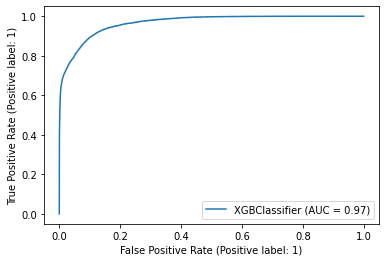

In [9]:
# ROC-AUC curve of model based on test set
plot_roc_curve(rs_model, X_test, y_test);

### 4.2.2 Bayesian Optimization<a id="Bayesian_Optimization"></a>

In [10]:
# Get train set performance
y_pred_train = bo_model.predict(X_train)
print("Train set performance: ", recall_score(y_train, y_pred_train))

# Get test set performance
y_pred_test = bo_model.predict(X_test)
print("Test set performance: ", recall_score(y_test, y_pred_test))

Train set performance:  0.6649137568363483
Test set performance:  0.6423423423423423


In [11]:
# Best parameters chosen by Bayesian optimization 
show_params(bo_model, param_list)

eta  =  0.6000000000000001
max_depth  =  5
min_child_weight  =  4
colsample_bytree  =  0.45000000000000007
gamma  =  0.30000000000000004


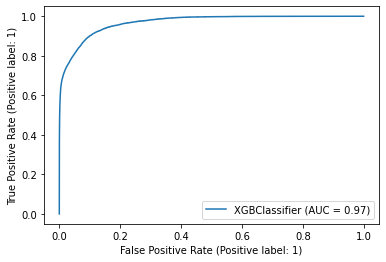

In [12]:
# ROC-AUC curve of model based on test set
plot_roc_curve(bo_model, X_test, y_test);

The metrics are essentially the same across the board, with both models scoring a recall of 0.642 on the test set and an AUC of 0.97. 

## 4.3 Confusion Matrix<a id="Confusion_Matrix"></a>

In [13]:
y_pred = bo_model.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

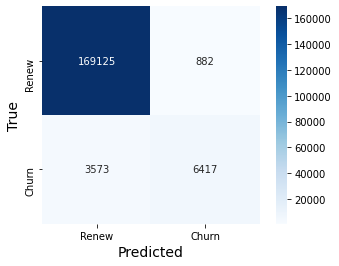

In [14]:
label = ["Renew", "Churn"]
sns.heatmap(pl, annot=True, fmt='.6g', cmap='Blues', square=True, xticklabels=label, yticklabels=label)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show();

## 4.4 Classification Report<a id="Classification_Report"></a>

In [15]:
report = classification_report(y_test, y_pred, target_names=["Renew", "Churn"])
print(report)

              precision    recall  f1-score   support

       Renew       0.98      0.99      0.99    170007
       Churn       0.88      0.64      0.74      9990

    accuracy                           0.98    179997
   macro avg       0.93      0.82      0.86    179997
weighted avg       0.97      0.98      0.97    179997



## 4.5 Feature Importance<a id="Feature_Importance"></a>

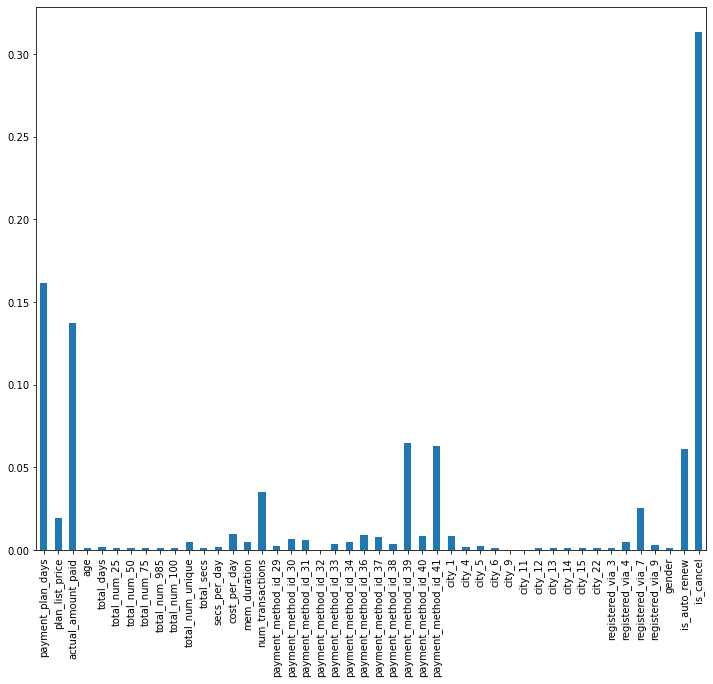

In [30]:
feat_importance = pd.DataFrame(bo_model.feature_importances_, index=X_test.columns.to_list())
feat_importance.plot(kind="bar", figsize=(12,10), legend=None)
plt.show();

Whether or not a user has canceled the service has the most significant effect on predicting churn, but this is a mostly negligible result as the very definition of churn includes that a user has canceled their subscription and made no new transactions within 30 days. 

It is very interesting to see the importance of the length and price of subscriptions. In the heatmap produced in EDA, we also saw that these features were highly correlated with churn. 

## 4.6 Modeling Scenarios<a id="Modeling_Scenarios"></a>

In our problem statement, our criteria of success was defined as showing a statistically significant decrease in churn in the upcoming month, April 2017. 

With this goal in mind, let's examine KKBox's current situation. 

This chart of the number of new subscribers added each month since KKBox's founding in 2004 reveals that while overall the number of new subscribers has been increasing, there has been a sharp downward trend in recent months:

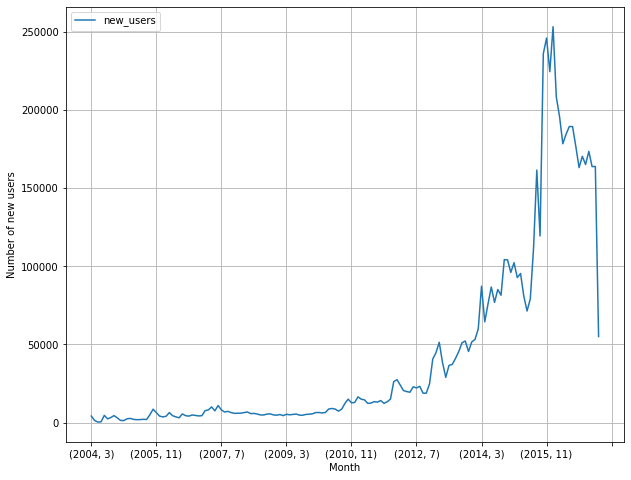

In [17]:
# Read in members_v3.csv file
members_df = pd.read_csv("../data/raw/members_v3.csv")

# Find the number of new subscribers who registered each month 
members_df["registration_init_time"] = pd.to_datetime(members_df["registration_init_time"], format="%Y%m%d")
monthly_new_users = {}
for year in range(2004, 2017+1):
    for month in range(1, 12+1):
        num_new_users = sum((members_df["registration_init_time"].dt.year==year) & \
                         (members_df["registration_init_time"].dt.month==month))
        monthly_new_users[(year,month)] = num_new_users
        
# Graph the number of new users added each month 
new_users_df = pd.DataFrame.from_dict(monthly_new_users, orient="index", columns=["new_users"])

# drop months at the extremities that have no data, as well as our current month
new_users_df = new_users_df[new_users_df.new_users>0].drop((2017,3))

new_users_df.plot(figsize=(10,8),grid=True)
plt.xlabel("Month")
plt.ylabel("Number of new users")
plt.show();

Furthermore, the percentage of new subscribers who churn is significantly higher than the percentage of older subscribrs who churn. Thus, at the same time that the number of new subscribers is dwindling, those who do sign up for the service are churning at higher rates: 

In [18]:
# Read in fully wrangled dataset 
original_data = pd.read_csv("../data/processed/combined.csv")
dtype_map = pd.read_csv("../data/processed/dtype_map.csv", index_col="feature").to_dict()["type"]
original_data = original_data.astype(dtype_map)

Percent of subscribers who both registered and churned in March 2017: 18.22%
Percent of subscribers who churned overall: 5.63%


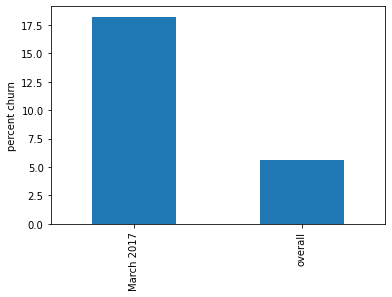

In [19]:
# Number subscribers who both registered and churned in March 2017
first_time = original_data[(original_data["registration_init_time"].dt.year==2017) & \
                           (original_data["registration_init_time"].dt.month==3)]
new_user_pct_churn = (first_time.is_churn.value_counts()[1] / first_time.shape[0])*100
overall_pct_churn = (original_data.is_churn.value_counts()[1] / original_data.shape[0])*100
print("Percent of subscribers who both registered and churned in March 2017: {:.2f}%".format(new_user_pct_churn))
print("Percent of subscribers who churned overall: {:.2f}%".format(overall_pct_churn))

# Graph comparing percent churn in March 2017 to churn overall
compare_churn = pd.DataFrame.from_dict({"March 2017":new_user_pct_churn, "overall":overall_pct_churn}, 
                                           orient="index", columns=["percent churn"])
compare_churn.plot(kind="bar", ylabel="percent churn", legend=None);

The combination of these challenges makes an adjustment to KKBox's strategy for retaining subscribers all the more essential to implement as soon as possible.  




In [20]:
# Function to test new scenarios
def scenario(columns, change, model=bo_model, test_data=X_test, old_pred=y_pred):
    """
    Given columns and a change, applys change to given columns in test set
    Parameters:
        columns: columns to apply change to in order to model a scenario
         change: value to multiply the given columns by to simulate a change
          model: defaults to the xgboost model tuned by Bayesian optimization as defined above
           data: defaults to a copy of the test data with a "churn_risk" column to identify 
                   subscribers at risk of churn
       old_pred: defaults to predicted churn by xgboost model 
       
    Returns:
        Dataframe with changes for the scenario applied
        prints three statements:
            1. amount of churn predicted without the changes
            2. about of churn with changes applied
            3. percent difference in churn
            
    """
    # Copy test data so we don't make changes to the original test dataset 
    data = test_data.copy()
    data["churn_risk"] = old_pred
    mask = data["churn_risk"]==1
    data.loc[mask, columns] = data.loc[mask, columns] * change
    data = data.drop("churn_risk", axis=1)
    new_pred = model.predict(data)
    print("Total churn in test set without change:", sum(old_pred))
    print("Total churn in test set with change:", sum(new_pred))
    count = data.shape[0]
    pct_decrease = (sum(old_pred)/count)*100 - (sum(new_pred)/count)*100
    print("Percent decrease in churn: {:.2f}%".format(pct_decrease))
    return data
    

### 4.6.1 Providing Discounts<a id="Providing_Discounts"></a>

We will apply a 50% discount to the subscribers that our model predicted will churn, the predict churn again. 

In [21]:
discounts = scenario("actual_amount_paid", 0.5);

Total churn in test set without change: 7299
Total churn in test set with change: 7032
Percent decrease in churn: 0.15%


Giving subscribers at risk of churn a 50% discount did make a slight difference in likelyhood to churn. 

### 4.6.2 Increasing User Engagement<a id="Increasing_User_Engagement"></a>

In EDA, we saw that user engagement did not appear to have a significant impact on likelyhood of churning. Let's test if that holds true for our models predictions by multiplying the amount of time the users at risk of churn spend on the app by 2. 

In [22]:
user_logs = ['total_num_25', 'total_num_50', 'total_num_75',
       'total_num_985', 'total_num_100', 'total_num_unique']

more_engagement = scenario(user_logs, 2);

Total churn in test set without change: 7299
Total churn in test set with change: 6942
Percent decrease in churn: 0.20%


Against our observations in EDA, we see that getting users to engage more with the app could lead to a slight decrease in churn. 

### 4.6.3 Smaller Plans<a id="Smaller_Plans"></a>

In the EDA stage, we observed that users who churned were paying three times as much for their subscriptions and had signed up for plans lasting three times as long. Additionally, in the graph of feature importance above, we see that the length and cost of plans are the most important features our model identified in determining likelyhood of churn. 

Let's reduce the plan length and amount paid for subscribers at risk of churn to a third of the original amounts: 

In [23]:
smaller_plans = scenario(["payment_plan_days", "plan_list_price", "actual_amount_paid"], 0.33)

Total churn in test set without change: 7299
Total churn in test set with change: 6737
Percent decrease in churn: 0.31%


Our observations from EDA and the chart of feature importance are confirmed. Switching subscribers at risk of churn to shorter plans with smaller monthly costs reduces churn the most out of the scenarios we have models thus far. 

### 4.6.4 Auto-Renew<a id="Auto-Renew"></a>

In EDA, we did not see auto-renew have a significant effect on churn. We will have all subscribers at risk of churn sign up for auto-renew, then predict how this change will affect their likelyhood of churn. 

In [24]:
auto_renew = X_test.copy()
auto_renew["churn_risk"] = y_pred
mask = auto_renew["churn_risk"] == 1
auto_renew.loc[mask, "is_auto_renew"] = 1
new_pred = bo_model.predict(auto_renew.drop("churn_risk", axis=1))
count = len(new_pred)
pct_decrease = (sum(y_pred)/count)*100 - (sum(new_pred)/count)*100
print("Total churn in test set without change:", sum(y_pred))
print("Total churn in test set with change:", sum(new_pred))
print("Percent decrease in churn: {:.2f}%".format(pct_decrease))

Total churn in test set without change: 7299
Total churn in test set with change: 7171
Percent decrease in churn: 0.07%


Our model matches our expected results based on EDA. The auto-renew option is not predicted to have a significant effect on churn. 

### 4.6.5 Combining Scenarios<a id="Combining_Scenarios"></a>

A combination of models could lead to greater success. Let's combine the two most successful scenarios, increasing user enagagement and switching users to smaller plans:

In [25]:
combined = scenario(["payment_plan_days", "plan_list_price", "actual_amount_paid"], 0.33, test_data=more_engagement)

Total churn in test set without change: 7299
Total churn in test set with change: 6539
Percent decrease in churn: 0.42%


This combined approach gives us the best results, with 760 subscribers who were at risk of churn changing course and renewing their subscriptions. Let's see if there is an additional improvement by also providing these users a 50% discount for a month:

In [26]:
multiple = scenario("actual_amount_paid", 0.5, test_data=combined);

Total churn in test set without change: 7299
Total churn in test set with change: 6311
Percent decrease in churn: 0.55%


Adding in our third best performing scenario, giving subscribers a 50% discount, reduces churn by an additional 0.13%. 

## 4.7 Statistical Significance<a id="Statistical_Significance"></a>

Is this decrease in churn statistically significant? 

__Null hypothesis:__ There is no relationship between the selected features (user engagement with the app, subscription cost and duration, and getting a discount) and likelyhood of churn. 

In [27]:
# Build a contingency table 
old_prediction = pd.Series(y_pred).value_counts()
new_prediction = pd.Series(bo_model.predict(multiple)).value_counts()
contingency_table = pd.DataFrame({"old_prediction":old_prediction, 
                                "new_prediction": new_prediction})
contingency_table = contingency_table.rename({0:"renew", 1:"churn"})
contingency_table

,old_prediction,new_prediction
renew,172698,173686
churn,7299,6311


In [28]:
# Get the statistic, p-value, degrees of freedom, and expected frequencies
stat, p, dof, expected = chi2_contingency(contingency_table)

In [29]:
print("p_value: {:.20f} ".format(p))

p_value: 0.00000000000000000641 


With a p_value this low, we can confidently conclude that our results are statistically significant. We can reject the null hypothesis and conclude that increasing user engagement, changing the subscription monthly cost, and providing subscribers at risk of churn with a 50% discount all have an effect on churn. 